<a href="https://colab.research.google.com/github/siddesai80/covid_detection_ANN/blob/main/ANN_Covid_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing important libraries


In [1]:
import os
import cv2
import random
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import Input,Dense,Flatten,MaxPooling2D,Conv2D,Dropout,Activation,BatchNormalization,SimpleRNN
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, Rescaling
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

# disabling warnings
import logging
logging.getLogger('tensorflow').disabled = True

print('All packages are Imported Successfully.')

All packages are Imported Successfully.


### Pre-processing data

In [2]:
# Setting train and test directories
train_dir='/content/drive/MyDrive/Datasets/ANN/xray_dataset_covid19/train'
test_dir='/content/drive/MyDrive/Datasets/ANN/xray_dataset_covid19/test'

In [3]:
# Printing the sub-directories
print(os.listdir(train_dir))
print(os.listdir(test_dir))

['PNEUMONIA', 'NORMAL']
['PNEUMONIA', 'NORMAL']


/content/drive/MyDrive/Datasets/ANN/xray_dataset_covid19/train/NORMAL/IM-0059-0001.jpeg
/content/drive/MyDrive/Datasets/ANN/xray_dataset_covid19/train/NORMAL/IM-0061-0001.jpeg
/content/drive/MyDrive/Datasets/ANN/xray_dataset_covid19/train/PNEUMONIA/covid-19-pneumonia-7-PA.jpg
/content/drive/MyDrive/Datasets/ANN/xray_dataset_covid19/train/PNEUMONIA/ryct.2020200028.fig1a.jpeg
/content/drive/MyDrive/Datasets/ANN/xray_dataset_covid19/train/PNEUMONIA/446B2CB6-B572-40AB-B01F-1910CA07086A.jpeg
/content/drive/MyDrive/Datasets/ANN/xray_dataset_covid19/train/NORMAL/IM-0069-0001.jpeg


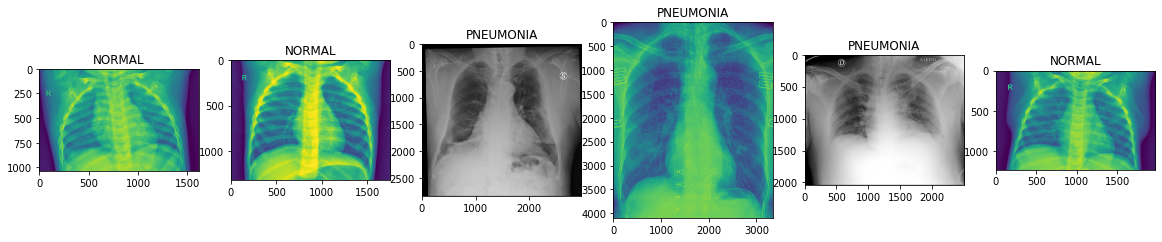

In [4]:
# Displaying random images from the training folder
img_folder='/content/drive/MyDrive/Datasets/ANN/xray_dataset_covid19/train'
plt.figure(figsize=(20,20))
for i in range(6):
 class_=random.choice(os.listdir(img_folder))
 class_path=os.path.join(img_folder, class_)
 file=random.choice(os.listdir(class_path))
 image_path=os.path.join(class_path,file)
 print(image_path)
 img=mpimg.imread(image_path)
 ax=plt.subplot(1,6,(i+1))
 plt.imshow(img)
 ax.title.set_text(class_)

In [5]:
# Creating a function to standardise all the image files
def create_dataset(img_folders_path, img_width, img_height):
    images = []
    labels = []
    num_images = 0
    for dirpath, _, filenames in os.walk(img_folders_path):
        for filename in filenames:
            img_path = os.path.join(dirpath, filename)
            image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (img_width, img_height))
            image = image.astype('float32') / 255
            images.append(image)
            class_name = os.path.basename(dirpath)
            labels.append(class_name)
            num_images += 1
    return np.array(images), np.array(labels), num_images

In [6]:
# Converting the images by calling the function
IMG_WIDTH=224
IMG_HEIGHT=224
train_img,train_target,num_img=create_dataset(train_dir,IMG_WIDTH,IMG_HEIGHT)
test_img,test_target,num_test_img=create_dataset(test_dir,IMG_WIDTH,IMG_HEIGHT)

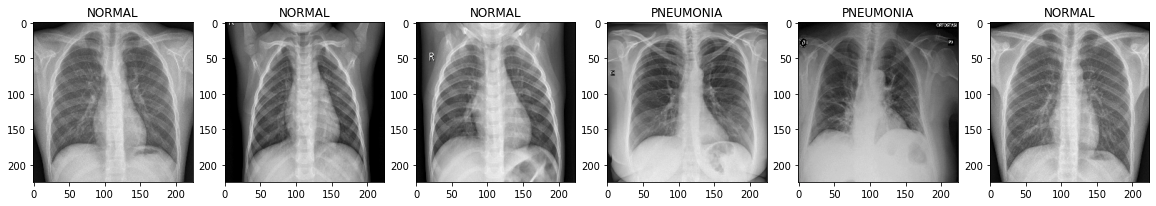

In [7]:
# Displaying the new images after pre-processing
plt.figure(figsize=(20,20))
for i in range(6):
    random_num = random.randint(0,num_img)
    ax=plt.subplot(1,6,(i+1))
    plt.imshow(train_img[random_num])
    ax.title.set_text(train_target[random_num])

In [8]:
# Convert text labels to numeric codes
target_dict={k: v for v, k in enumerate(np.unique(train_target))}
print(target_dict)
train_target= [target_dict[train_target[i]] for i in range(len(train_target))]
train_target=np.array(train_target)
train_img=np.array(train_img)
test_target= [target_dict[test_target[i]] for i in range(len(test_target))]
test_target=np.array(test_target)
test_img=np.array(test_img)

{'NORMAL': 0, 'PNEUMONIA': 1}


# CNN Model

## Defining and Fitting Model

In [9]:
# Early stopping for preventing overfitting
early_stopping = EarlyStopping(monitor='loss', restore_best_weights=False, patience=10)

# Define a Sequential model
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, kernel_size=(3,3), activation="relu",input_shape=(224,224,3)))

# Add a second convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))

# Add a max pooling layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Add dropout regularization
model.add(Dropout(0.25))

# Repeating the above steps to make a deeper network.
model.add(Conv2D(128, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation = "relu"))

# Add more dropout regularization
model.add(Dropout(0.5))

# Create an output sigmoid function
model.add(Dense(1, activation="sigmoid"))

#Compile the model: binary_crossentropy because this is a binary classification problem; adam as the optimizer; the metric that we want to monitor is accuracy.
model.compile(loss="binary_crossentropy", optimizer="adam",metrics = ["accuracy"])

# Printe the model architecture to take a look at the number of parameters that the model will learn.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                    

In [10]:
# Fit the model
model.fit(train_img, train_target, 
          validation_split=0.10, 
          epochs=20, 
          batch_size=32, 
          shuffle=True,
          callbacks=[early_stopping]
        )

Epoch 1/20
5/5 [==============================] - 15s 457ms/step - loss: 4.0977 - accuracy: 0.4511 - val_loss: 0.7448 - val_accuracy: 0.0000e+00
Epoch 2/20
5/5 [==============================] - 1s 177ms/step - loss: 0.6655 - accuracy: 0.6165 - val_loss: 0.5689 - val_accuracy: 1.0000
Epoch 3/20
5/5 [==============================] - 1s 175ms/step - loss: 0.6653 - accuracy: 0.6391 - val_loss: 0.6694 - val_accuracy: 0.7333
Epoch 4/20
5/5 [==============================] - 1s 174ms/step - loss: 0.5505 - accuracy: 0.6992 - val_loss: 0.4199 - val_accuracy: 1.0000
Epoch 5/20
5/5 [==============================] - 1s 174ms/step - loss: 0.5204 - accuracy: 0.7895 - val_loss: 0.5151 - val_accuracy: 0.8000
Epoch 6/20
5/5 [==============================] - 1s 177ms/step - loss: 0.3919 - accuracy: 0.8346 - val_loss: 0.5189 - val_accuracy: 0.7333
Epoch 7/20
5/5 [==============================] - 1s 173ms/step - loss: 0.4114 - accuracy: 0.8421 - val_loss: 0.0968 - val_accuracy: 1.0000
Epoch 8/20
5/5 

## Plotting loss function and accuracy

In [11]:
# Storing training and validation metrics
losses = pd.DataFrame(model.history.history)
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,4.097701,0.451128,0.744779,0.000000
1,0.665450,0.616541,0.568867,1.000000
2,0.665284,0.639098,0.669373,0.733333
3,0.550511,0.699248,0.419851,1.000000
4,0.520428,0.789474,0.515146,0.800000


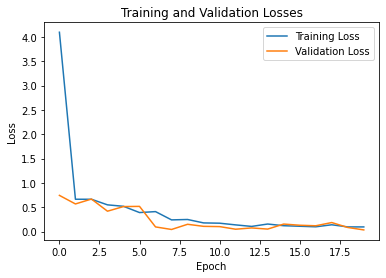

In [12]:
# Plotting Training and Validation Losses
losses[['loss','val_loss']].plot()
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

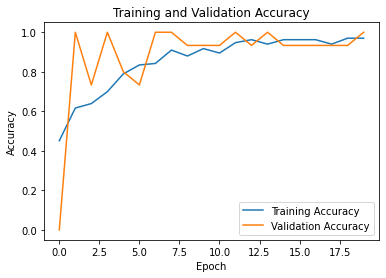

In [13]:
# Plotting Training and Validation Accuracy
losses[['accuracy', 'val_accuracy']].plot()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

## Predicting the results

In [14]:
# Predictions on test set
pred = model.predict(test_img,batch_size=32)

label = [int(p>=0.5) for p in pred]

# Printing Accuracy Score
print ('Accuracy Score : ', accuracy_score(label, test_target), '\n')

# Printing Classification report
print ('Classification Report :\n\n' ,classification_report(label, test_target))

2/2 [==============================] - 0s 355ms/step
Accuracy Score :  1.0 

Classification Report :

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



# Xception Model

## Defining and Fitting Model

In [15]:
# Creating train and test datasets
xception_train_data = image_dataset_from_directory(directory = train_dir,
                                         image_size = (224, 224),
                                         label_mode = "binary",
                                         batch_size = 32,
                                         seed = 42)

xception_test_data = image_dataset_from_directory(directory = test_dir,
                                         image_size = (224, 224),
                                         label_mode = "binary",
                                         batch_size = 32,
                                         seed = 42)

Found 148 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


In [16]:
# Create a data augmentation pipeline with horizontal flipping, rotations, and zooms
data_augmentation_pipeline = keras.Sequential([
  preprocessing.RandomFlip(mode="horizontal"),
  preprocessing.RandomRotation(factor=0.2),
  preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
  preprocessing.RandomHeight(factor=0.2),
  preprocessing.RandomWidth(factor=0.2)
], name="data_augmentation")

# Create a normalization pipeline
normalization_pipeline = keras.Sequential([
    preprocessing.Rescaling(scale=1./255.)
], name="normalization")

In [17]:
# Define input shape
input_shape = (224, 224, 3)

# Saving best model while monitoring accuracy
model_checkpoint = ModelCheckpoint('best_mod', save_best_only=True, verbose = 1)

# Define Xception base model
xception_base = tf.keras.applications.xception.Xception(include_top=False)

# Create input layer
input_layer = layers.Input(shape = input_shape, name = "Input_Layer")

# Add data augmentation as a layer
x = data_augmentation_pipeline(input_layer)

# Add normalization layer
x = normalization_pipeline(x)

# Pass inputs through the Xception base model
x = xception_base(x, training = False)

# Add global average pooling layer to condense output of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "Pooling_Layer")(x)

# Add a dense output layer with sigmoid activation function
output_layer = layers.Dense(1, activation = "sigmoid", name = "Output_Layer")(x)

# Create the final model by specifying inputs and outputs
xception_model = keras.Model(input_layer, output_layer)

83683744/83683744 [==============================] - 5s 0us/step


In [18]:
# Compile the model
xception_model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"] 
)

In [19]:
# Display the model summary
xception_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 normalization (Sequential)  (None, None, None, 3)     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 Pooling_Layer (GlobalAverag  (None, 2048)             0         
 ePooling2D)                                                     
                                                                 
 Output_Layer (Dense)        (None, 1)                 2049  

In [20]:
# Fit the model
xception_model.fit(xception_train_data,
                    epochs=20,
                    steps_per_epoch=len(xception_train_data),
                    validation_data=xception_test_data,
                    validation_steps=len(xception_test_data),
                    callbacks=[early_stopping,model_checkpoint]) 

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 0.7470 - accuracy: 0.4595
Epoch 1: val_loss improved from inf to 0.69315, saving model to best_mod


5/5 [==============================] - 85s 12s/step - loss: 0.7470 - accuracy: 0.4595 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 2: val_loss did not improve from 0.69315
5/5 [==============================] - 18s 3s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000
Epoch 3: val_loss did not improve from 0.69315
5/5 [==============================] - 21s 4s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/20
5/5 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.4865
Epoch 4: val_loss did not improve from 0.69315
5/5 [==============================] - 25s 5s/step - loss: 0.6951 - accuracy: 0.4865 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/20
5/5 [==============================] - ETA: 0s - loss: 0.6931 -

In [21]:
# Number of layers in our base model, and their trainablity status
for i, layer in enumerate(xception_model.layers):
    print(i, layer.name, layer.trainable)

0 Input_Layer True
1 data_augmentation True
2 normalization True
3 xception True
4 Pooling_Layer True
5 Output_Layer True


## Plotting loss function and accuracy

In [22]:
# Storing training and validation metrics
losses = pd.DataFrame(xception_model.history.history)
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,0.747010,0.459459,0.693147,0.5
1,0.693147,0.500000,0.693147,0.5
2,0.693155,0.500000,0.693147,0.5
3,0.695071,0.486486,0.693148,0.5
4,0.693147,0.500000,0.693148,0.5


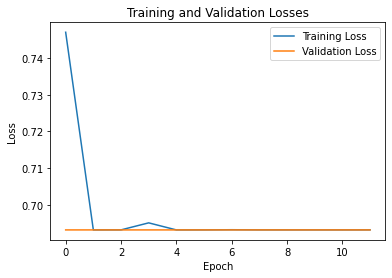

In [23]:
# Plotting Training and Validation Losses
losses[['loss','val_loss']].plot()
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

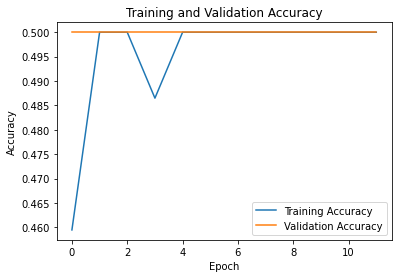

In [24]:
# Plotting Training and Validation Accuracy
losses[['accuracy', 'val_accuracy']].plot()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

## Evaluating the model

In [25]:
# Loading the model we saved during training using checkpoint and evaluating the test data with it
final_model = tf.keras.models.load_model("best_mod")
final_model.evaluate(xception_test_data)

2/2 [==============================] - 2s 51ms/step - loss: 0.6931 - accuracy: 0.5000


[0.6931471824645996, 0.5]